# Programmentwurf
In dieser Aufgabe wollen wir Bilder in 6 verschiedene Klassen klassifizieren: "Häuser, Wald, Gletscher, Berge, Wasser, Straße".

## Laden einiger wichtiger Bibliotheken

In [1]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plot
from random import randint
import random

## Laden weiterer Bibliotheken
Soweit benötigt können natürlich weiter Python-Bibliotheken geladen werden. Bitte diese Bibliotheken im unteren Codeblock einfügen.

In [2]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_curve, auc,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.applications import MobileNetV2
from keras.layers import  GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.models import load_model

## Dictionary/Map von Klassenname zu Index
Wir bauen ein Mapping zwischen Klassenlabel und Klassenindex

In [3]:
labelMap = {'buildings':0, 'forest':1, 'glacier':2, 'mountain':3, 'sea':4, 'street':5}
keyMap = {v: k for k, v in labelMap.items()}
class_labels = list(labelMap.keys())
print(labelMap)
print(keyMap)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
{0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}


Methode um Bilder aus einem Verzeichnis zu laden

In [4]:
def get_images(directory):
    Images = []
    Labels = []  
    label = 0
    
    for dirName in os.listdir(directory):
        #print(dirName)
        label = labelMap[dirName]
        
        for image_file in os.listdir(directory+dirName): 
            image = cv2.imread(directory+dirName+r'/'+image_file) 
            im_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            if image.shape == (150, 150, 3):
                Images.append(im_rgb)
                Labels.append(label)
    
    return Images,Labels

## Laden der Trainingsdaten
Wir laden die Trainingsdaten aus den angegebenen Zip-Dateien

In [5]:
x_train, Y_train = get_images('Data/train/')

## Konvertiere Bilder in Numpy-Arrays

In [6]:
x_train = np.array(x_train) 
Y_train = np.array(Y_train)

In [7]:
print("Shape of Images:",x_train.shape)
print("Shape of Labels:",Y_train.shape)

Shape of Images: (13986, 150, 150, 3)
Shape of Labels: (13986,)


## Zählen der einzelnen Bildklassen
Für einen ersten Eindruck wollen wir wissen, ob die einzelnen Klassen in etwa gleichverteilt sind.

In [8]:
unique_elements, counts_elements = np.unique(Y_train, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[   0    1    2    3    4    5]
 [2190 2263 2387 2495 2270 2381]]


## Plotten der Daten

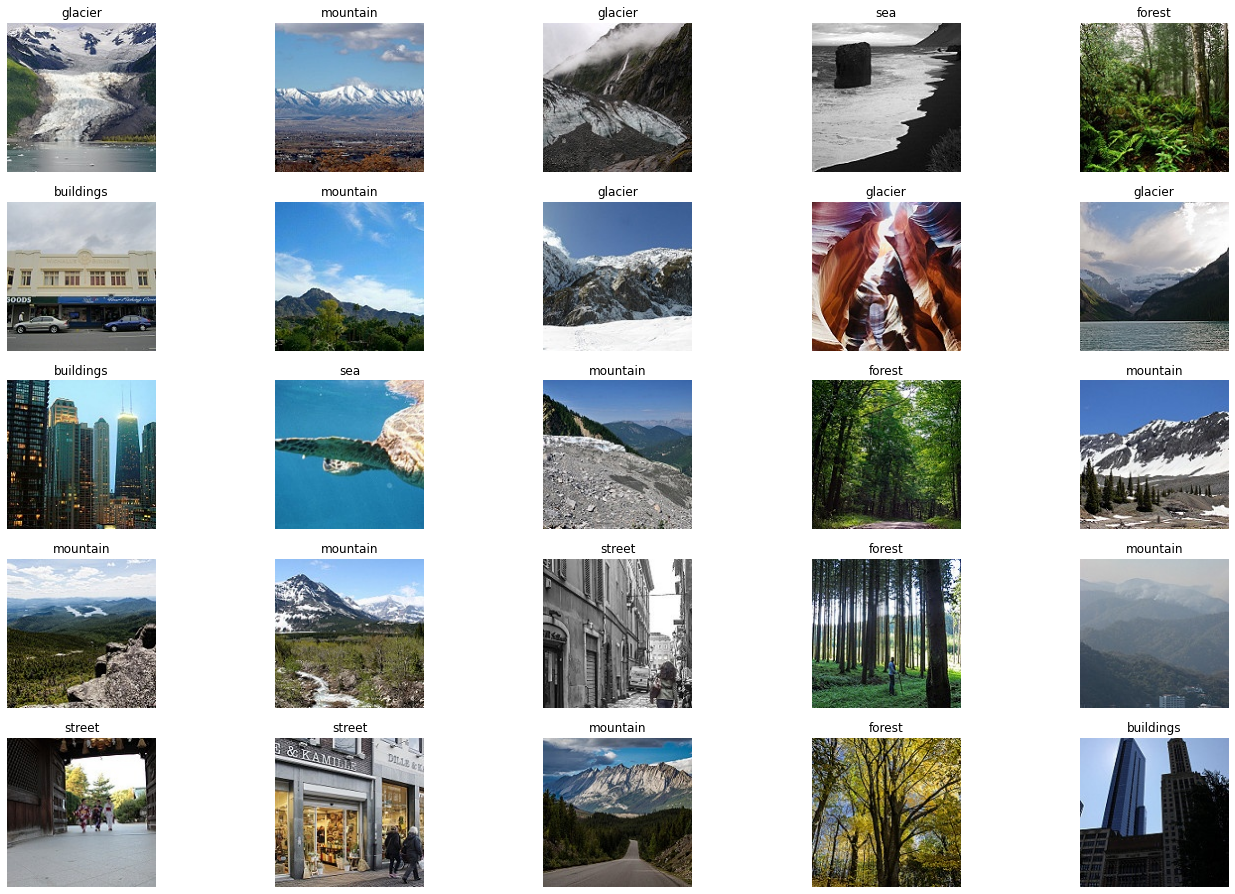

In [9]:
random.seed(1202)
f,ax = plot.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(x_train))
        ax[i,j].imshow(x_train[rnd_number])
        ax[i,j].set_title(keyMap[Y_train[rnd_number]])
        ax[i,j].axis('off')

## 1.)  Erstellen Sie ein Evaluationsszenario  (5 Punkte)

### 1.1) Erstellen Sie einen stratifizierten Train/Dev-Split (80%-Train / 20%-Dev). 

Zuerst nehmen wir die nach Klassen sortierten Trainingsdaten und Shuffeln sowohl das x_train als auch y_train. Sonst hätte es das Modell nachher denkbar einfach zu erlernen, wann welches Bild kommt, da es einfach die aufsteigende Reihenfolge erlernen könnte. Wichtig ist außerdem, dass x & y mit dem selben seed geshuffelt werden, um zu den Daten auch die richtigen Labels zu erhalten.


In [10]:
x_train, Y_train = shuffle(x_train, Y_train, random_state=0)

Stimmen die Labels noch nach dem Shuffeln?

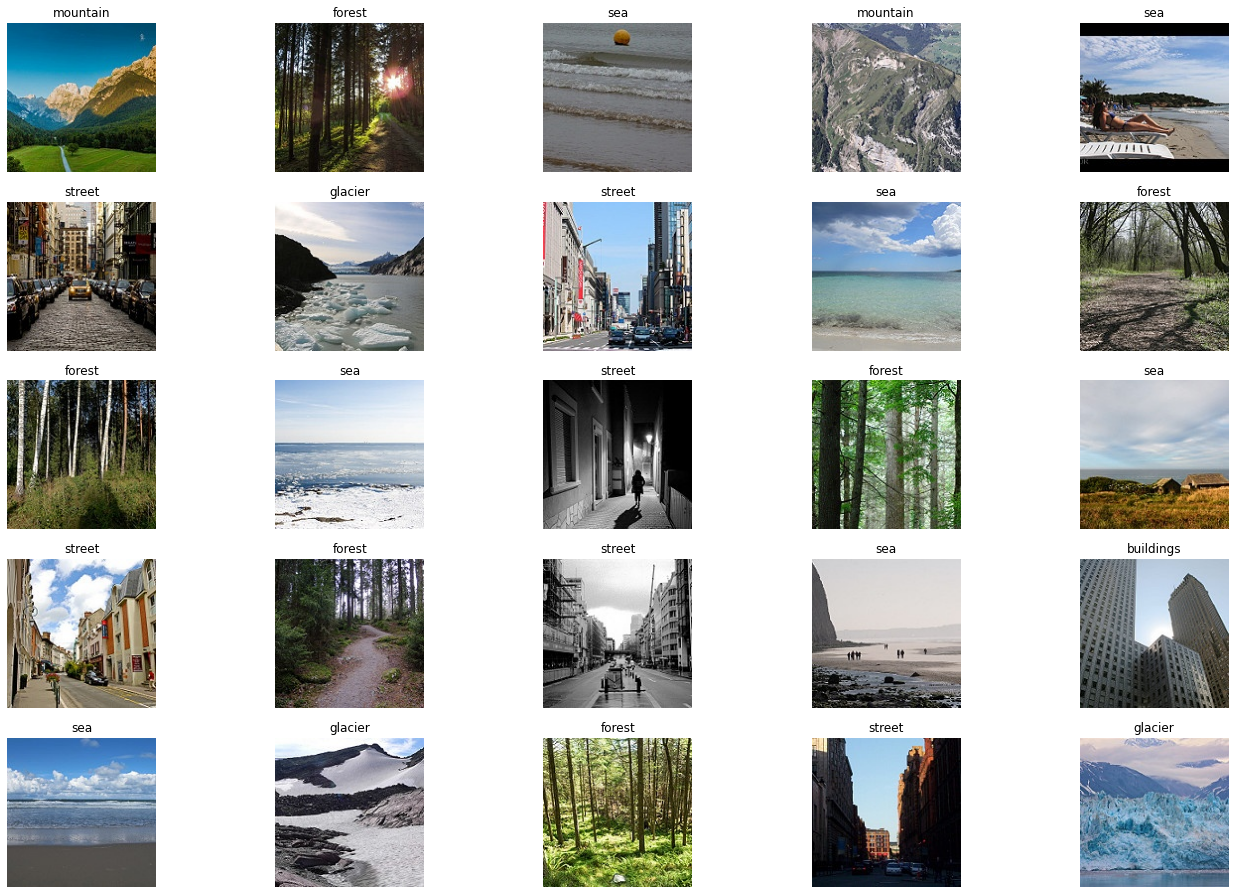

In [11]:
random.seed(1202)
f,ax = plot.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(x_train))
        ax[i,j].imshow(x_train[rnd_number])
        ax[i,j].set_title(keyMap[Y_train[rnd_number]])
        ax[i,j].axis('off')

Sieht gut aus :) 


Nun können wir einfach die ersten 80% der gemischten Daten als Trainingsdaten verwenden und die restlichen 20% als Dev

In [12]:
x_train_, x_dev_, y_train_, y_dev_ = train_test_split(x_train, Y_train,
                                                   test_size=0.2,
                                                   stratify=Y_train)

### 1.2) Veranschaulichen Sie, dass die Splits wirklich stratifiziert sind


Sind alle Daten in Train und Dev Unterteilt?

In [13]:
all_data_used = x_train_.shape[0]+x_dev_.shape[0] == x_train.shape[0]
all_data_used

True

Ist die Verteilung noch relativ gleich?

In [14]:
unique_elements, counts_elements_org = np.unique(Y_train, return_counts=True)
unique_elements, counts_elements_train = np.unique(y_train_, return_counts=True)
unique_elements, counts_elements_dev = np.unique(y_dev_, return_counts=True)

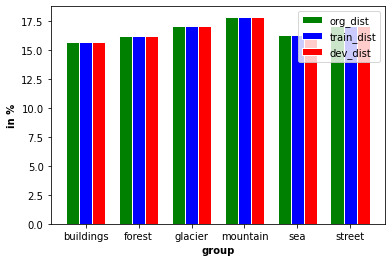

In [15]:

barWidth = 0.25
bars1 = (counts_elements_org/x_train.shape[0])*100
bars2 = (counts_elements_train/x_train_.shape[0])*100
bars3 = (counts_elements_dev/x_dev_.shape[0])*100
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, bars1, color='green', width=barWidth, edgecolor='white', label='var1')
plt.bar(r2, bars2, color='blue', width=barWidth, edgecolor='white', label='var2')
plt.bar(r3, bars3, color='red', width=barWidth, edgecolor='white', label='var3')
 
# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.ylabel("in %", fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], class_labels)
 
# Create legend & Show graphic
plt.legend(labels=["org_dist","train_dist","dev_dist"])
plt.show()


# Kopiert und angepasst von : https://www.python-graph-gallery.com/11-grouped-barplot

Im oberen Graph sieht man, dass die orginale Verteilung der Daten sehr genau der der Traing & Dev- Splits gleicht

### 1.3) Laden Sie die Testdaten (test.zip) und veranschaulichen Sie deren Verteilung

In [16]:
x_test, Y_test = get_images('Data/test/')
x_test = np.array(x_test) 
Y_test = np.array(Y_test)
print("Shape of Images:",x_test.shape)
print("Shape of Labels:",Y_test.shape)

Shape of Images: (2993, 150, 150, 3)
Shape of Labels: (2993,)


Die Verteilung ist wie folgt:

In [17]:
unique_elements, counts_elements_test = np.unique(Y_test, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[   0    1    2    3    4    5]
 [2190 2263 2387 2495 2270 2381]]


Die Verteilung der Daten aus dem Train und dem Test Ordner im Vergleich:

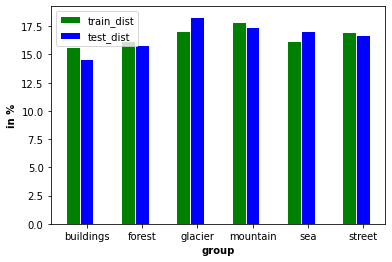

In [18]:
barWidth = 0.25
bars1 = (counts_elements_org/x_train.shape[0])*100
bars2 = (counts_elements_test/x_test.shape[0])*100

 

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

 

plt.bar(r1, bars1, color='green', width=barWidth, edgecolor='white', label='var1')
plt.bar(r2, bars2, color='blue', width=barWidth, edgecolor='white', label='var2')

 

plt.xlabel('group', fontweight='bold')
plt.ylabel("in %", fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], class_labels)
 

plt.legend(labels=["train_dist","test_dist"])
plt.show()

# Kopiert und angepasst von : https://www.python-graph-gallery.com/11-grouped-barplot

##  2.) Trainieren Sie eine Baseline  (10 Punkte)

### 2.1) Trainieren Sie (auf den Trainingsdaten) einen Naive Bayes-Klassifikator, welcher alle 6 Bildklassen erkennt. 

In [20]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_reshaped = x_train_.reshape(x_train_.shape[0], 150*150*3)
X_train_scaled = scaler.fit_transform(X_train_reshaped) #Skalierung der Pixelwerte auf[0,1]

X_dev_reshaped = x_dev_.reshape(x_dev_.shape[0], 150*150*3)
X_dev_scaled = scaler.fit_transform(X_dev_reshaped) #Skalierung der Pixelwerte auf[0,1]

In [21]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

# Create classifiers
clf1 = GaussianNB()
clf2 = BernoulliNB()
clf3 = MultinomialNB()

# Fit classifiers to training data
clf1.fit(X_train_scaled, y_train_)
clf2.fit(X_train_scaled, y_train_)
clf3.fit(X_train_scaled, y_train_)

# Predict on test data
y_pred1 = clf1.predict(X_dev_scaled)
y_pred2 = clf2.predict(X_dev_scaled)
y_pred3 = clf3.predict(X_dev_scaled)

# Compute accuracy scores
acc1 = accuracy_score(y_dev_, y_pred1)
acc2 = accuracy_score(y_dev_, y_pred2)
acc3 = accuracy_score(y_dev_, y_pred3)

# Print results
print("Accuracy for GaussianNB:", acc1)
print("Accuracy for BernoulliNB:", acc2)
print("Accuracy for MultinomialNB:", acc3)

Accuracy for GaussianNB: 0.45639742673338096
Accuracy for BernoulliNB: 0.3745532523230879
Accuracy for MultinomialNB: 0.4431736954967834


### 2.2) Evaluieren Sie diesen Klassifikator auf dem Test-Set (Accuracy)


In [22]:
X_test_reshaped = x_test.reshape(x_test.shape[0], 150*150*3)
X_test_scaled = scaler.transform(X_test_reshaped)
y_pred = clf1.predict(X_test_scaled)
accuracy = accuracy_score(Y_test, y_pred)
precission = precision_score(Y_test, y_pred,average='macro')
recall = recall_score(Y_test, y_pred,average='macro')
f1_score = f1_score(Y_test, y_pred,average='macro')
print("Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1-Score: {:.3f}".format(accuracy, precission, recall, f1_score))

Accuracy: 0.466, Precision: 0.458, Recall: 0.463, F1-Score: 0.442


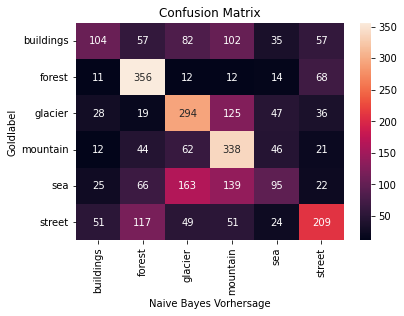

In [23]:
conf_matrix = confusion_matrix(Y_test, y_pred)
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Naive Bayes Vorhersage')
plt.ylabel('Goldlabel')
plt.title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_labels,rotation='vertical')
ax.yaxis.set_ticklabels(class_labels,rotation='horizontal')
plt.show()

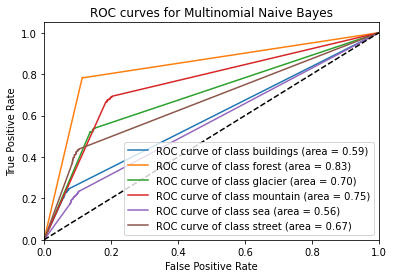

In [24]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# Use the trained classifier to make predictions on the validation data
y_pred_prob = clf1.predict_proba(scaler.transform(x_dev_.reshape(x_dev_.shape[0], 150*150*3)))

# Compute the ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_dev_, y_pred_prob[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure()
for i in range(len(class_labels)):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for Multinomial Naive Bayes')
plt.legend(loc="lower right")
plt.show()

## 3.)  Trainieren Sie ein Neuronales Netz zur Bilderkennung (20 Punke)

### 3.1) Entwickeln Sie ein mehrschichtiges CNN-Model mit Dropout


In [ ]:

model = Sequential()


model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))  

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))  

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))  


model.add(Flatten())


model.add(Dense(len(class_labels), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ProgbarLogger
from sklearn.preprocessing import StandardScaler

logger = ProgbarLogger()
scaler = StandardScaler()

x_train_ = scaler.fit_transform(x_train_.reshape(x_train_.shape[0], -1))
x_train_ = x_train_.reshape(x_train_.shape[0], 150, 150, 3)
y_train_ = to_categorical(y_train_)

x_dev_ = scaler.fit_transform(x_dev_.reshape(x_dev_.shape[0], -1))
x_dev_ = x_dev_.reshape(x_dev_.shape[0], 150, 150, 3)
y_dev_ = to_categorical(y_dev_)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
train_data = model.fit(x_train_, y_train_, epochs=25, batch_size=32, validation_data=(x_dev_, y_dev_), callbacks=[tensorboard,early_stopping])

Epoch 1/25
350/350 [==============================] - 280s 798ms/step - loss: 7.5236 - accuracy: 0.2650 - val_loss: 1.7707 - val_accuracy: 0.2012
Epoch 2/25
350/350 [==============================] - 291s 830ms/step - loss: 1.5039 - accuracy: 0.4044 - val_loss: 1.3809 - val_accuracy: 0.4721
Epoch 3/25
350/350 [==============================] - 274s 783ms/step - loss: 1.3323 - accuracy: 0.4814 - val_loss: 1.1877 - val_accuracy: 0.5282
Epoch 4/25
350/350 [==============================] - 274s 783ms/step - loss: 1.1620 - accuracy: 0.5559 - val_loss: 0.9937 - val_accuracy: 0.6158
Epoch 5/25
350/350 [==============================] - 275s 787ms/step - loss: 0.9550 - accuracy: 0.6386 - val_loss: 0.8926 - val_accuracy: 0.6365
Epoch 6/25
350/350 [==============================] - 272s 776ms/step - loss: 0.8056 - accuracy: 0.7030 - val_loss: 0.7781 - val_accuracy: 0.7062
Epoch 7/25
350/350 [==============================] - 272s 777ms/step - loss: 0.7078 - accuracy: 0.7444 - val_loss: 0.7213 -

### 3.2) Entwickeln Sie ein beliebiges neuronales Modell (z.B. Residual-connections, mehr/weniger Schichten als 3.1 etc)


In [ ]:

input_shape = (150, 150, 3)

base_model = MobileNetV2(weights='imagenet', 
                         include_top=False, 
                         input_shape=input_shape)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_labels), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

train_data = model.fit(x_train_, y_train_, batch_size=32, epochs=50,validation_data=(x_dev_, y_dev_),
callbacks=[EarlyStopping(monitor='val_loss', patience=5), TensorBoard(log_dir='./logs')])

Epoch 1/50
350/350 [==============================] - 217s 605ms/step - loss: 0.7415 - accuracy: 0.7345 - val_loss: 0.3373 - val_accuracy: 0.8853
Epoch 2/50
350/350 [==============================] - 175s 500ms/step - loss: 0.4160 - accuracy: 0.8517 - val_loss: 0.3134 - val_accuracy: 0.8921
Epoch 3/50
350/350 [==============================] - 176s 504ms/step - loss: 0.3506 - accuracy: 0.8725 - val_loss: 0.3057 - val_accuracy: 0.8914
Epoch 4/50
350/350 [==============================] - 170s 486ms/step - loss: 0.3178 - accuracy: 0.8844 - val_loss: 0.2989 - val_accuracy: 0.8971
Epoch 5/50
350/350 [==============================] - 165s 471ms/step - loss: 0.3032 - accuracy: 0.8910 - val_loss: 0.2945 - val_accuracy: 0.8942
Epoch 6/50
350/350 [==============================] - 167s 478ms/step - loss: 0.2672 - accuracy: 0.9021 - val_loss: 0.2899 - val_accuracy: 0.8992
Epoch 7/50
350/350 [==============================] - 161s 461ms/step - loss: 0.2533 - accuracy: 0.9056 - val_loss: 0.2907 -

In [ ]:
model.save('path/to/save/MobileNetv2_Durchlauf1.h5', include_optimizer=True)

In [ ]:
from keras.applications import InceptionV3
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam

input_shape = (150, 150, 3)

base_model = InceptionV3(weights='imagenet', 
                         include_top=False, 
                         input_shape=input_shape)

for layer in base_model.layers[-3:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_labels), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

train_data = model.fit(x_train_, y_train_, batch_size=32, epochs=50,validation_data=(x_dev_, y_dev_),
callbacks=[EarlyStopping(monitor='val_loss', patience=5), TensorBoard(log_dir='./logs')])


87910968/87910968 [==============================] - 2s 0us/step


c:\Users\timos\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
350/350 [==============================] - 1377s 4s/step - loss: 0.6598 - accuracy: 0.7631 - val_loss: 0.2971 - val_accuracy: 0.9089
Epoch 2/50
350/350 [==============================] - 1432s 4s/step - loss: 0.2869 - accuracy: 0.9054 - val_loss: 0.2798 - val_accuracy: 0.9092
Epoch 3/50
350/350 [==============================] - 1415s 4s/step - loss: 0.1724 - accuracy: 0.9433 - val_loss: 0.3178 - val_accuracy: 0.9114
Epoch 4/50
350/350 [==============================] - 1504s 4s/step - loss: 0.1370 - accuracy: 0.9563 - val_loss: 0.3908 - val_accuracy: 0.8960
Epoch 5/50
350/350 [==============================] - 1350s 4s/step - loss: 0.1194 - accuracy: 0.9620 - val_loss: 0.3361 - val_accuracy: 0.9121
Epoch 6/50
350/350 [==============================] - 1395s 4s/step - loss: 0.0917 - accuracy: 0.9693 - val_loss: 0.3907 - val_accuracy: 0.9096
Epoch 7/50
350/350 [==============================] - 1414s 4s/step - loss: 0.0668 - accuracy: 0.9774 - val_loss: 0.4048 - val_accuracy:

In [ ]:
model.save('path/to/save/Inceptionv3_Durchlauf1.h5', include_optimizer=True)

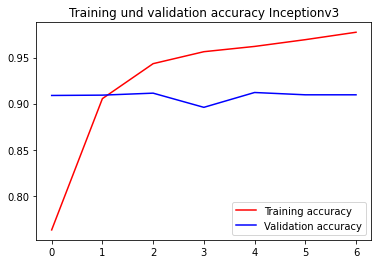

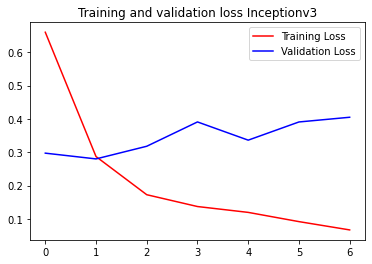

In [ ]:
acc = train_data.history['accuracy']
val_acc = train_data.history['val_accuracy']
loss = train_data.history['loss']
val_loss = train_data.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training und validation accuracy Inceptionv3')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss Inceptionv3')
plt.legend()

### 3.3) Visualisieren Sie die Architekturen der beiden Modelle


In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_6[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]']         

### 3.4) Plotten Sie für beide Modelle den Loss und die Accuracy über 10 Epochen
Beobachten Sie Anzeichen von Overfitting? Würden Sie das Modell für weitere Epochen trainieren wollen? Begründen Sie Ihre Antwort


In [ ]:
from IPython.display import HTML
HTML('<img src="pics\FirstCNNTensorboardAccuracy.png">')

In [ ]:
from IPython.display import HTML
HTML('<img src="pics\FirstCNNTensorboardLoss.png">')

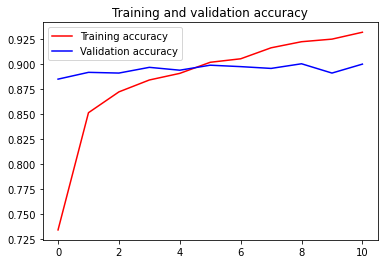

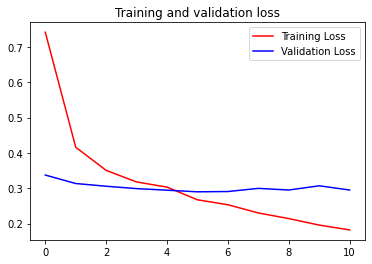

In [ ]:
acc = train_data.history['accuracy']
val_acc = train_data.history['val_accuracy']
loss = train_data.history['loss']
val_loss = train_data.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training und validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

## 4.) Evaluieren und interpretieren Sie das Netzwerk auf den Test-Daten (20)


### 4.1) Vergleichen Sie die Performanz beider neuronalen Modelle und die baseline. Welches Modell würden Sie produktiv einsetzen? Alle weiteren Analysen erfolgen auf dem, Ihrer Meinung nach, besseren (neuronalen) Modell


### 4.2) Schätzen Sie die Genauigkeit/Accuracy Ihrer Methode für jede Klasse separat, sowie für alle Klasse


### 4.3) Erzeugen Sie eine Confusion Matrix 


In [ ]:
# Code

### 4.4) Interpretation der Confusion-Matrix. Welche Klasse ist am schwersten zu klassifizieren und mit welchen Klassen wird sie oft „verwechselt“


## 5.) Geben Sie für ein ausgewähltes Testbild (example-150.png) die Klassenwahrscheinlichkeiten aus (5 Punkte)


### 5.1) Wenden Sie Ihr Modell auf das Testbild (example-150.png) an.
Plotten Sie das ausgewählte Bild und nennen Sie die 6 Wahrscheinlichkeiten der einzelnen Bildklassen


In [ ]:
# Code

## 6.) Trainieren Sie für jede der beiden neuronalen Architekturen mehrere Modelle (20 Punkte)



### 6.1) Definieren Sie (mindestens) 5 random seeds 


### 6.2) Trainieren Sie für jeden random seed die Modelle (3.1 und 3.2)


### 6.3) Evaluieren Sie alle Modelle auf den Testdaten 


### 6.4) Plotten Sie die Verteilungen (Accuracy) der beiden Modelle als Boxplot oder Violin plot


### 6.5) Interpretieren Sie die Ergebnisse. Welches der beiden Modelle ist besser?


## 7.) Bauen Sie ein (einfaches) Ensemble  (20 Punkte)


### 7.1 Implementieren Sie ein einfaches majority-voting Ensemble (Empfehlung nehmen Sie die Modelle aus 6)

### 7.2) Evaluieren Sie den Ensemble-Klassifikator auf dem Test-set

### 7.3 Wie ist die Performanz des Ensembles im Vergleich zu den einzelnen Modellen? Welches Modell würden Sie am Ende einsetzen? Begründen Sie Ihre Antwort.

## 8.) Bitte schätzen Sie den benötigten Zeitaufwand für die Übung (optional)

Für die Übungen habe ich **XY Stunden** benötigt. Gerne auch detailliertere Abschätzungen  (pro Übung). 